In [105]:
# Internal utilities
from soln.data_loader import load

# External dependencies
import pylab as py
import numpy as np

import time

In [106]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import get_scorer, mean_squared_error, r2_score
from sklearn.feature_selection import RFECV


def evaluate_estimator(estimator, 
                       hyperparameters = {}, 
                       x_features = ['z_enc_1', "dx_enc_1", "dy_enc_1"],
                       y_label = 'fx_1'):
            
    df_train = load("Test1.csv")
    X_train = df_train[x_features]
    y_train = df_train[y_label]
    
    df_validate = load("Test2.csv")
    X_validate = df_validate[x_features]
    y_validate = df_validate[y_label]

    # Use the sklearn machinery to do... 1-fold "CV" 
    # (just a single validation score training on Test1 and evaluating hyperparameters on Test2)
    X = np.concatenate([X_train, X_validate])
    y = np.concatenate([y_train, y_validate])

    split_idx = X_train.shape[0]
    cv_iterator = [
        [list(range(split_idx)), 
         list(range(split_idx, split_idx + X_validate.shape[0]))]
    ]

    cv_estimator = GridSearchCV(
        estimator, 
        hyperparameters,
        cv = cv_iterator,
        n_jobs = 8,
        scoring = "neg_root_mean_squared_error"
    )

    # Hyperparameter search
    model = cv_estimator.fit(X, y)
    
    # Evaluate best estimator on the hold-out Test4 trace
    df_test = load("Test4.csv")
    X_test = df_test[x_features].to_numpy()
    y_test = df_test[y_label].to_numpy()
    
    model = model.fit(X, y)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_pred=y_pred, y_true=y_test, squared=False)
        
    return dict(label = y_label, model = model, test_error = rmse)

# Don't overthink it

Random forest regressors are great, no nonsense, estimators. As a first pass, take the modest feature engineering from the data exploration step and just throw the kitchen sink at an RF.

For fun, I also tried starving the model of some features that seemed redundant (e.g., remove global x, y positions since these features shouldn't generalize). However, RF's do a great job deprioritizing unhelpful features and still squeezing some juice out of them. Ultimately, the best feature set tended to be the full list (- t). 

In [107]:
# Kitchen sink estimator
kitchen_sink = ['t']
kitchen_sink += ['{}_enc_{}'.format(k, i) for k in ['x', 'y', 'z'] for i in [1,2]] 
kitchen_sink += ['d{}_enc_1'.format(k) for k in ['x', 'y', 'z']] 
kitchen_sink += ['{}_enc_{}'.format(k, i) for k in ['a', 'b', 'c'] for i in [1,2]]
kitchen_sink += ['R12_d{}'.format(k) for k in ['x', 'y', 'z']] 

# Subset of features that you would expect to be predictive 
# (drop t, drop all global position info in favor of local arm movement (dx/dt))
x_intuitive = [] 
x_intuitive += ['{}_enc_{}'.format(k, i) for k in ['z'] for i in [1]] 
x_intuitive += ['d{}_enc_1'.format(k) for k in ['x', 'y', 'z']]
x_intuitive += ['{}_enc_{}'.format(k, i) for k in ['a', 'b', 'c'] for i in [1,2]]
x_intuitive += ['R12_d{}'.format(k) for k in ['x', 'y', 'z']] 

results = []
for estimator in [RandomForestRegressor(max_depth=16, n_estimators=128)]:
    for label in ['fx_1', 'fy_1', 'fz_1']:
        for feature_list in [
            kitchen_sink, 
            set(kitchen_sink) - set('t'), 
            x_intuitive,
        ]:
            t0 = time.time()            
            features = sorted(list(feature_list))

            print()
            print(features)
            
            cv_results = evaluate_estimator(
                estimator, 
                dict(),
                x_features=features,
                y_label=label,
            )

            results.append(dict(
                cv_results = cv_results,
                label = label,
                validation_err = -cv_results['model'].best_score_, 
                test_err = cv_results['test_error'],
                features = features
            ))
            
            print(time.time() - t0)
            print(results[-1])


['R12_dx', 'R12_dy', 'R12_dz', 'a_enc_1', 'a_enc_2', 'b_enc_1', 'b_enc_2', 'c_enc_1', 'c_enc_2', 'dx_enc_1', 'dy_enc_1', 'dz_enc_1', 't', 'x_enc_1', 'x_enc_2', 'y_enc_1', 'y_enc_2', 'z_enc_1', 'z_enc_2']
239.90595650672913
{'cv_results': {'label': 'fx_1', 'model': GridSearchCV(cv=[[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                   18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                  [19847, 19848, 19849, 19850, 19851, 19852, 19853, 19854,
                   19855, 19856, 19857, 19858, 19859, 19860, 19861, 19862,
                   19863, 19864, 19865, 19866, 19867, 19868, 19869, 19870,
                   19871, 19872, 19873, 19874, 19875, 19876, ...]]],
             estimator=RandomForestRegressor(max_depth=16, n_estimators=128),
             n_jobs=8, param_grid={}, scoring='neg_root_mean_squared_error'), 'test_error': 164.83312284899677}, 'label': 'fx_1', 'validation_err': 127.62864540986651, 'test_err': 164.83312284899677, 'feature

225.25269865989685
{'cv_results': {'label': 'fz_1', 'model': GridSearchCV(cv=[[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                   18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                  [19847, 19848, 19849, 19850, 19851, 19852, 19853, 19854,
                   19855, 19856, 19857, 19858, 19859, 19860, 19861, 19862,
                   19863, 19864, 19865, 19866, 19867, 19868, 19869, 19870,
                   19871, 19872, 19873, 19874, 19875, 19876, ...]]],
             estimator=RandomForestRegressor(max_depth=16, n_estimators=128),
             n_jobs=8, param_grid={}, scoring='neg_root_mean_squared_error'), 'test_error': 392.6533246748789}, 'label': 'fz_1', 'validation_err': 134.65757331350332, 'test_err': 392.6533246748789, 'features': ['R12_dx', 'R12_dy', 'R12_dz', 'a_enc_1', 'a_enc_2', 'b_enc_1', 'b_enc_2', 'c_enc_1', 'c_enc_2', 'dx_enc_1', 'dy_enc_1', 'dz_enc_1', 'x_enc_1', 'x_enc_2', 'y_enc_1', 'y_enc_2', 'z_enc_1', 'z_enc_2']}

['

In [111]:
import pandas as pd
results_df = pd.DataFrame(results)
results_df.groupby('label').min('test_err')

,validation_err,test_err
label,,
fx_1,127.628645,157.228577
fy_1,109.266042,211.245473
fz_1,108.135808,221.066239


In [112]:
def visualize_model_performance(label, model, x_features):
    df = load("Test4.csv")
    X = df[x_features].to_numpy()
    y = df[label].to_numpy()
    
    y_pred = model.predict(X)
    
    # PvA
    py.figure(figsize=(4, 3))
    py.title("Predicted v.s. Actual ({};Test4.csv)".format(label))
    py.scatter(y_pred, y, alpha=0.1)
    py.xlim(y.min(), y.max())
    py.ylim(y.min(), y.max())

    # Look at at a high error slice
    sorted_err = sorted(zip(list(range(len(y_pred))), list(y_pred - y)), key = lambda x: x[-1])
    
    err_idx = sorted_err[0][0]
    err_slice = slice(err_idx - 50, err_idx + 50)
    
    py.figure(figsize=(4, 3))
    py.title("High error slice")
    py.plot(y_pred[err_slice], label="Predicted")
    py.plot(y[err_slice], label="Actual")
    py.legend()

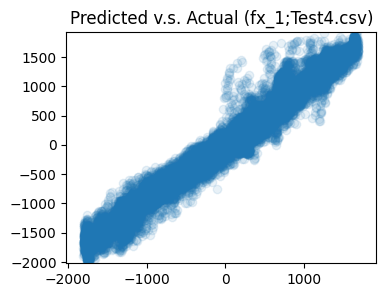

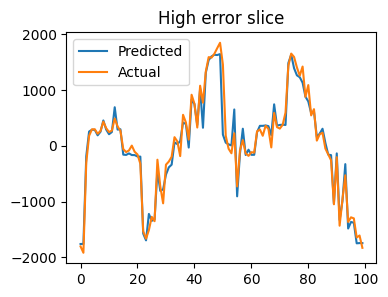

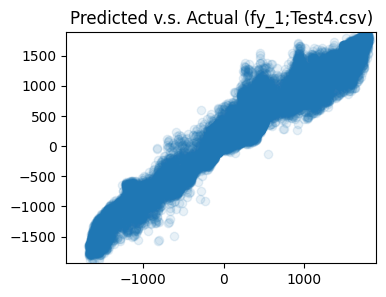

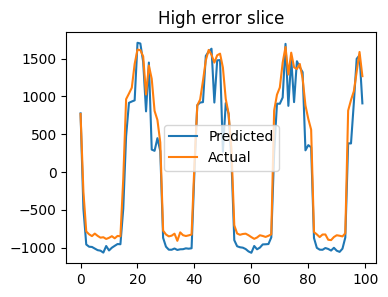

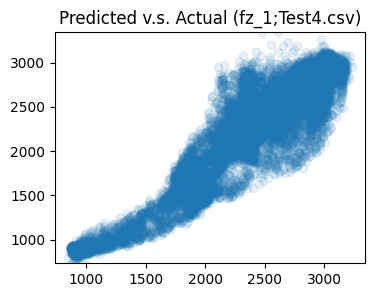

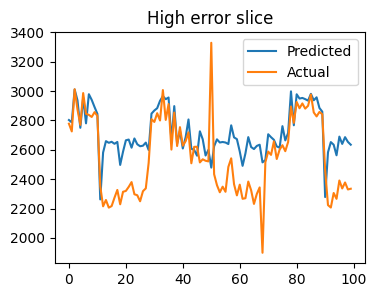

In [113]:
# Pluck out the best model settings for each label
best_models = {}

for row in results:
    if best_models.get(row['label'], [None, 1E10])[1] > row['test_err']:
        best_models[row['label']] = [row, row['test_err']]
        
# For each force label (R1 for now, but easily extended to R2), visualize the PvA curve and high error segments
for label in ['fx_1', 'fy_1', 'fz_1']:
    best_model = best_models[label][0]    
    
    model = best_model['cv_results']['model']
    x_features = best_model['features']
    
    visualize_model_performance(label, model, x_features)

# Modeling summary

Overall, I'm actually surprised at how feasible it was to RF our way to a decent model. I'd love to see performance on a significantly different geometry, as the 3 files we have here all represent ~the same figure so it is hard to really tell how well it is generalizing. 

Still, with minimal feature engineering, the x and y forces were captured well. The z-forces were worse, which looks like it generally overestimates when it gets the force wrong. To dig in a little bit, before finally closing the book on this problem (for now!), here is the same 3D visualization from the data exploration but for fz_1 error.

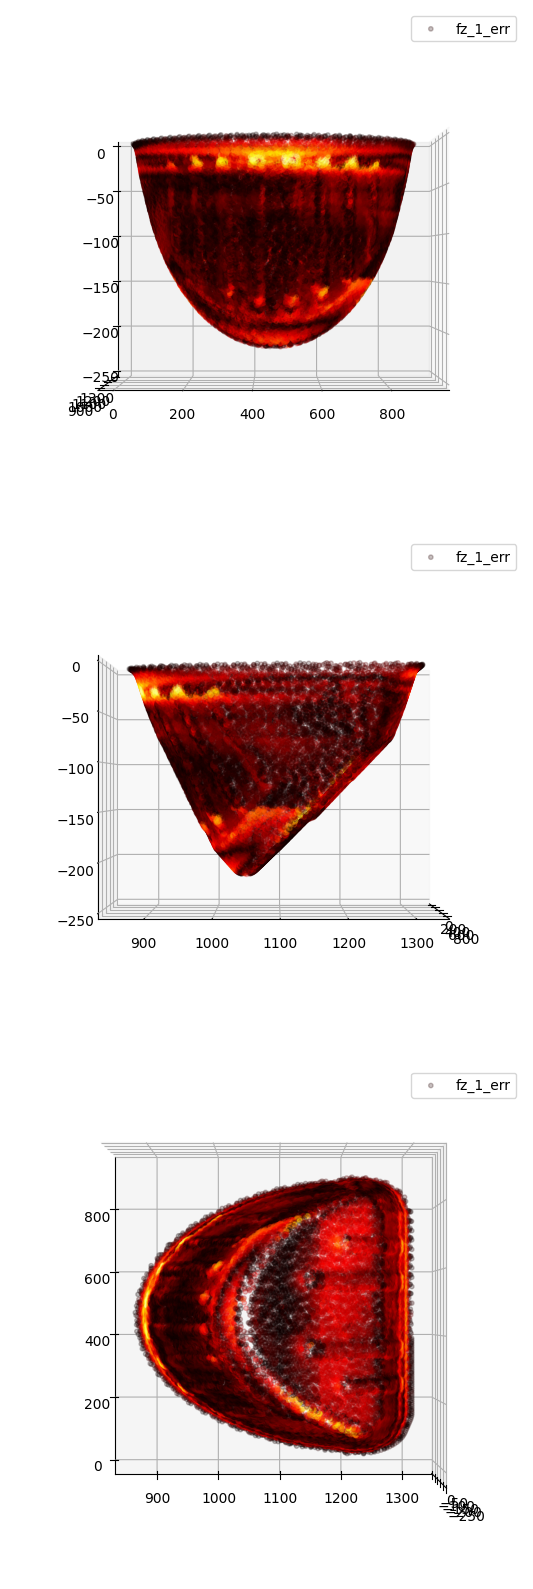

In [118]:
def plot_3d_point_dynamics(slc, df, color_by, ax = None, view = [20, -120]):
    from matplotlib import cm
    import numpy as np

    if ax is None:
        py.figure()
        ax = py.subplot(projection='3d')
        
    ax.view_init(*view)
    
    for R_idx in [1]:
        # Prepare arrays x, y, z        
        t = np.abs(df[color_by].to_numpy())[slc]      
        t = 1.0 * t - t.min()
        t = t / t.max()
        
        x = df["x_enc_{}".format(R_idx)].to_numpy()[slc]
        y = df["y_enc_{}".format(R_idx)].to_numpy()[slc]
        z = df["z_enc_{}".format(R_idx)].to_numpy()[slc]
        
        # ax.plot(x, y, z, label=color_by)
        ax.scatter(x, y, z, color=cm.hot(t), s = 10, label=color_by, alpha=0.25)
        ax.legend()
        
        ax.set_zlim(-250, 0)
        
        
df = load("Test4.csv")

label = "fz_1"
best_model = best_models[label][0]    
model = best_model['cv_results']['model']
x_features = best_model['features']
df['fz_1_err'] = df['fz_1'] - model.predict(df[x_features].to_numpy())
    
slc = slice(0, -1)
view = [-10, -25]

idx = 1
fig = py.figure(figsize=(16, 16))
for color_by in ["fz_1_err"]:
    for view in [
        [0, -90],
        [0, 0],
        [-90, 0]]:

        ax = fig.add_subplot(3, 1, idx, projection='3d')
        plot_3d_point_dynamics(slc, df, ax = ax, color_by=color_by, view=view)

        idx += 1

fig.tight_layout()

Interesting -- the error hotspots are near the top and tail of the flute features. Something to dig into!